In [1]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import numpy as np
import random
import tensorflowjs as tfjs

In [2]:
import pandas as pd

df = pd.read_csv("the-circor-digiscope-phonocardiogram-dataset-1.0.3/training_data.csv")

In [3]:
patient_id = list(df["Patient ID"])
recording_loc = list(df["Recording locations:"])
murmur = list(df["Murmur"])
murmur_loc = list(df["Murmur locations"])
systolic_murmur_timing = list(df["Systolic murmur timing"])

In [4]:
recording_loc = [x.split("+") for x in recording_loc]

for i in range(len(murmur_loc)):
    if murmur_loc[i] is np.nan:
        murmur_loc[i] = []
    else:
        murmur_loc[i] = murmur_loc[i].split("+")

In [5]:
X = []
y = []

for i in range(len(patient_id)):
    if murmur[i] == "Absent":
        for recloc in recording_loc[i]:
            full_recording = np.loadtxt("SSE/" + str(patient_id[i]) + "_" + recloc + "_features.csv", delimiter=',')
            initial = 0
            while (initial+400) <= len(full_recording):
                X.append(full_recording[initial:initial+400])
                y.append([1, 0, 0, 0, 0])
                initial += 200
    elif murmur[i] == "Present":
        for recloc in recording_loc[i]:
            if recloc in murmur_loc[i]:
                full_recording = np.loadtxt("SSE/" + str(patient_id[i]) + "_" + recloc + "_features.csv", delimiter=',')
                initial = 0
                if systolic_murmur_timing[i] == "Holosystolic":
                    while (initial+400) <= len(full_recording):
                        X.append(full_recording[initial:initial+400])
                        y.append([0, 1, 0, 0, 0])
                        initial += 200
                elif systolic_murmur_timing[i] == "Early-systolic":
                    while (initial+400) <= len(full_recording):
                        X.append(full_recording[initial:initial+400])
                        y.append([0, 0, 1, 0, 0])
                        initial += 200
                elif systolic_murmur_timing[i] == "Mid-systolic":
                    while (initial+400) <= len(full_recording):
                        X.append(full_recording[initial:initial+400])
                        y.append([0, 0, 0, 1, 0])
                        initial += 200
                elif systolic_murmur_timing[i] == "Late-systolic":
                    while (initial+400) <= len(full_recording):
                        X.append(full_recording[initial:initial+400])
                        y.append([0, 0, 0, 0, 1])
                        initial += 200
                else:
                    print("Error on patient ID:", patient_id[i])
            else:
                full_recording = np.loadtxt("SSE/" + str(patient_id[i]) + "_" + recloc + "_features.csv", delimiter=',')
                initial = 0
                while (initial+400) <= len(full_recording):
                    X.append(full_recording[initial:initial+400])
                    y.append([1, 0, 0, 0, 0])
                    initial += 200

Error on patient ID: 85119
Error on patient ID: 85119


In [6]:
time_steps = 400
feature_length = 18
batch_size = 3

In [7]:
from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.25)

In [8]:
X_train_final = []
y_train_final = []

for i in range(len(X_train)):
    if y_train[i] == [1, 0, 0, 0, 0]:
        #randnum = random.uniform(0, 1)
        randnum = random.random()
        if randnum >= 0.66:
            X_train_final.append(X_train[i])
            y_train_final.append(y_train[i])
    else:
        X_train_final.append(X_train[i])
        y_train_final.append(y_train[i])

In [9]:
print(len(X_train), len(y_train))
print(len(X_train_final), len(y_train_final))
print(len(X_test), len(y_test))

22341 22341
10047 10047
7447 7447


In [10]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_train_final = np.array(X_train_final)
y_train_final = np.array(y_train_final)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [11]:
model = Sequential()
model.add(LSTM(256, input_shape = (400, 18), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 400, 256)          281600    
_________________________________________________________________
dropout (Dropout)            (None, 400, 256)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 400, 128)          197120    
_________________________________________________________________
dropout_1 (Dropout)          (None, 400, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 528,453
Trainable params: 528,453
Non-trainable params: 0
__________________________________________________

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.fit(X_train_final, y_train_final, epochs=10, batch_size=batch_size)

Epoch 1/10
3349/3349 [==============================] - 297s 86ms/step - loss: 0.9843 - accuracy: 0.6410
Epoch 2/10
3349/3349 [==============================] - 293s 88ms/step - loss: 0.9737 - accuracy: 0.6460
Epoch 3/10
3349/3349 [==============================] - 315s 94ms/step - loss: 0.9611 - accuracy: 0.6434
Epoch 4/10
3349/3349 [==============================] - 318s 95ms/step - loss: 0.9477 - accuracy: 0.6531
Epoch 5/10
3349/3349 [==============================] - 314s 94ms/step - loss: 0.9495 - accuracy: 0.6519
Epoch 6/10
3349/3349 [==============================] - 320s 96ms/step - loss: 0.9436 - accuracy: 0.6539
Epoch 7/10
3349/3349 [==============================] - 311s 93ms/step - loss: 0.9205 - accuracy: 0.6649
Epoch 8/10
3349/3349 [==============================] - 318s 95ms/step - loss: 0.8927 - accuracy: 0.6857
Epoch 9/10
3349/3349 [==============================] - 306s 91ms/step - loss: 0.8795 - accuracy: 0.6919
Epoch 10/10
3349/3349 [==============================] 

In [14]:
final_final_predicts = model.predict(X_test)
final_final_predicts.shape

(7447, 5)

In [15]:
X = np.array(X)
y = np.array(y)
score_full = model.evaluate(X, y, batch_size=batch_size, verbose=0)
print('Test loss:', score_full[0])
print('Accuracy:', score_full[1])

Test loss: 0.7206341624259949
Accuracy: 0.778535008430481


In [16]:
score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
print('Test loss:', score[0])
print('Accuracy:', score[1])

Test loss: 0.7275599837303162
Accuracy: 0.7764200568199158


In [17]:
final_final_predicts

array([[4.39256638e-01, 3.23751569e-01, 1.57566532e-01, 7.54825771e-02,
        3.94267170e-03],
       [7.43687272e-01, 1.34744644e-01, 9.94000882e-02, 2.10352801e-02,
        1.13276346e-03],
       [1.90729827e-01, 4.87749398e-01, 1.78086087e-01, 1.39305681e-01,
        4.12905309e-03],
       ...,
       [8.00709844e-01, 1.03335984e-01, 8.06773230e-02, 1.45396981e-02,
        7.37072842e-04],
       [6.73107803e-01, 1.72605261e-01, 1.22602217e-01, 2.99033076e-02,
        1.78144325e-03],
       [2.13753104e-01, 4.81871784e-01, 1.91462189e-01, 1.09993711e-01,
        2.91922479e-03]], dtype=float32)

In [18]:
for i in range(len(final_final_predicts)):
    if max(final_final_predicts[i]) != final_final_predicts[i][0]:
        print(i, final_final_predicts[i])

2 [0.19072983 0.4877494  0.17808609 0.13930568 0.00412905]
4 [0.19075888 0.48451898 0.17042205 0.1485987  0.00570143]
15 [0.2223526  0.45167834 0.17599511 0.14198291 0.00799105]
18 [0.3169376  0.3894972  0.17711759 0.1108911  0.0055565 ]
27 [0.18052842 0.46932462 0.22137313 0.124575   0.00419886]
36 [0.30891657 0.39655903 0.19565369 0.09421376 0.00465697]
37 [0.2620234  0.43389475 0.17721249 0.12201281 0.00485658]
39 [0.10851601 0.5480741  0.15137191 0.18578358 0.00625439]
50 [0.3355991  0.38480943 0.17094503 0.10344288 0.00520354]
52 [0.24228795 0.4477595  0.17739673 0.12790468 0.00465115]
56 [0.09663077 0.54575956 0.16481557 0.18620528 0.00658884]
58 [0.3360308  0.38499787 0.16929294 0.10460223 0.00507625]
59 [0.19748667 0.47852165 0.17683949 0.14223637 0.00491582]
61 [0.26332784 0.4358222  0.17610142 0.12022381 0.00452481]
64 [0.21479617 0.4669218  0.1790458  0.13483232 0.00440379]
73 [0.17892027 0.496162   0.1715505  0.14880127 0.00456593]
76 [0.11515488 0.5286215  0.16822198 0.181

2267 [0.11178346 0.53772485 0.16044776 0.18330672 0.00673723]
2276 [0.27103448 0.4237812  0.18152826 0.11844934 0.00520665]
2277 [0.3457927  0.3772641  0.1679669  0.10339964 0.00557663]
2282 [0.16995195 0.49802557 0.18604982 0.14192912 0.00404352]
2287 [0.12277721 0.5350571  0.156002   0.17986754 0.00629613]
2294 [0.10562789 0.5463415  0.1556357  0.18597905 0.00641587]
2298 [0.10862213 0.5545422  0.14835155 0.18301241 0.00547171]
2303 [0.34906524 0.37189463 0.16861242 0.10459435 0.00583332]
2306 [0.21920449 0.4648716  0.17787877 0.13362941 0.00441578]
2313 [0.22776859 0.45646983 0.18056071 0.13060966 0.00459128]
2323 [0.20884004 0.47205186 0.17913279 0.13555245 0.0044229 ]
2326 [0.09277909 0.53790426 0.2012148  0.16440429 0.00369754]
2330 [0.13111314 0.52433735 0.15858139 0.17914838 0.00681969]
2335 [0.22986653 0.4443877  0.19150661 0.12923303 0.00500607]
2336 [0.1581262  0.50793153 0.18645102 0.14343767 0.00405357]
2338 [0.16351148 0.5069471  0.1620107  0.16137178 0.00615899]
2339 [0.

3070 [0.26151803 0.4318617  0.18241954 0.11957456 0.00462614]
3076 [0.17255487 0.4910689  0.19007039 0.14186835 0.00443739]
3078 [0.15631853 0.51441276 0.17594673 0.1490867  0.00423524]
3086 [0.30505684 0.4066287  0.17532004 0.10810223 0.00489219]
3088 [0.20011562 0.47748166 0.18728769 0.13075678 0.00435824]
3094 [0.09912918 0.5440498  0.18316138 0.16889146 0.00476817]
3106 [0.07835498 0.5413837  0.18795146 0.18779236 0.00451751]
3116 [0.2572355  0.43796408 0.17838053 0.12172437 0.00469546]
3118 [0.21131864 0.46381694 0.18298566 0.13707462 0.00480417]
3120 [0.3207648  0.39089966 0.17501712 0.10768719 0.00563117]
3138 [0.26149052 0.419602   0.19506755 0.11824538 0.00559446]
3146 [0.29859138 0.41162002 0.17004652 0.11479307 0.00494898]
3147 [0.13601743 0.5236331  0.19691326 0.13998356 0.00345265]
3148 [0.27646017 0.4237883  0.19334938 0.10298619 0.00341595]
3151 [0.13032936 0.531586   0.1606965  0.17177565 0.00561244]
3163 [0.19827062 0.48118767 0.17438455 0.1412369  0.00492032]
3164 [0.

4563 [0.19300634 0.48843163 0.16328958 0.14957443 0.00569795]
4565 [0.11298634 0.54804343 0.14855371 0.1843999  0.00601654]
4567 [0.08642168 0.5520596  0.16927843 0.18628223 0.00595812]
4571 [0.11436146 0.5430608  0.15716489 0.1793561  0.00605681]
4574 [0.15151499 0.51482725 0.18774055 0.1415219  0.0043953 ]
4580 [0.12055353 0.5230742  0.17430879 0.17526385 0.00679963]
4593 [0.29540986 0.3942498  0.22019142 0.08712652 0.00302243]
4596 [0.23030482 0.45473897 0.1791536  0.13111281 0.00468982]
4599 [0.19483608 0.48286366 0.18163317 0.13664863 0.00401839]
4612 [0.10817891 0.544763   0.15321472 0.1872602  0.00658314]
4617 [0.27467886 0.4254236  0.17642571 0.11851007 0.00496166]
4630 [0.2549624  0.43548033 0.18140247 0.123235   0.00491981]
4635 [0.09819284 0.54092467 0.17144315 0.18306859 0.00637078]
4639 [0.2154719  0.46847364 0.1826693  0.12919816 0.00418698]
4651 [0.18221909 0.5027429  0.16888589 0.1425317  0.00362045]
4655 [0.11201336 0.5216139  0.21805812 0.14558226 0.0027323 ]
4657 [0.

7233 [0.33579156 0.386147   0.16709891 0.10581949 0.00514305]
7237 [0.2933087  0.42461947 0.16759543 0.11032064 0.00415582]
7239 [0.36331412 0.3665575  0.16965552 0.0952195  0.00525334]
7256 [0.16822724 0.50156116 0.16407043 0.16006999 0.00607121]
7261 [0.24550265 0.43709156 0.18663694 0.12556912 0.00519967]
7264 [0.25024363 0.44240597 0.18607768 0.11714308 0.00412969]
7265 [0.11529052 0.5432666  0.1496052  0.18549109 0.00634665]
7267 [0.34534684 0.37461016 0.16833383 0.10586134 0.00584777]
7270 [0.24834658 0.43770128 0.19441238 0.11449371 0.00504608]
7276 [0.29791856 0.40295652 0.17586526 0.11751419 0.00574545]
7277 [0.18331781 0.49345833 0.1722787  0.14674145 0.00420379]
7281 [0.26376072 0.42983472 0.17891362 0.12241722 0.00507374]
7282 [0.3374555  0.38421622 0.16798842 0.10513677 0.00520316]
7286 [0.05651209 0.54404515 0.1985084  0.19764385 0.00329055]
7287 [0.27622136 0.41972676 0.18810514 0.11121028 0.00473644]
7288 [0.14533366 0.5143499  0.15963991 0.17395407 0.00672247]
7289 [0.

In [19]:
full_predicts = model.predict(X)
full_predicts

array([[0.7394907 , 0.13494234, 0.10346155, 0.02094056, 0.0011649 ],
       [0.72017694, 0.14575872, 0.10926662, 0.02345008, 0.00134761],
       [0.77320814, 0.1205466 , 0.08740169, 0.01794237, 0.00090116],
       ...,
       [0.73497903, 0.14677598, 0.09327959, 0.02389107, 0.00107435],
       [0.7310569 , 0.14942797, 0.09373607, 0.02465805, 0.0011209 ],
       [0.70970094, 0.16384487, 0.09683536, 0.02835494, 0.00126389]],
      dtype=float32)

In [20]:
for i in range(len(full_predicts)):
    if max(full_predicts[i]) != full_predicts[i][0]:
        print(i, full_predicts[i])

33 [0.1422674  0.5122396  0.20326568 0.13860531 0.003622  ]
38 [0.3321008  0.38039473 0.20519556 0.07975732 0.00255162]
39 [0.1657988  0.50586927 0.16014928 0.16107199 0.00711069]
40 [0.10956753 0.54130465 0.15713455 0.18548122 0.00651211]
50 [0.03465389 0.6310401  0.13801114 0.19435169 0.00194315]
51 [0.03705854 0.62894696 0.13545412 0.19609205 0.00244825]
52 [0.04275182 0.5873375  0.16827707 0.19906972 0.00256382]
53 [0.03911238 0.62942433 0.13851884 0.19063365 0.00231078]
54 [0.03120307 0.6024524  0.16028346 0.20424995 0.00181108]
55 [0.05373818 0.5721262  0.16702788 0.20284276 0.00426502]
56 [0.05945314 0.556495   0.18875064 0.19172594 0.00357532]
57 [0.06590281 0.55819464 0.17836715 0.19333914 0.0041963 ]
58 [0.06799723 0.5634475  0.17630723 0.18805197 0.00419611]
59 [0.07390881 0.55797184 0.16778192 0.19450757 0.00582989]
60 [0.15413424 0.5109497  0.16436961 0.16489121 0.00565522]
61 [0.11767108 0.53038085 0.18692522 0.15991202 0.00511085]
62 [0.09780713 0.5509232  0.18080992 0.1

2091 [0.12513189 0.5335841  0.15748774 0.17753337 0.00626295]
2092 [0.18338071 0.4898553  0.18249154 0.14018315 0.00408933]
2093 [0.2394642  0.44887608 0.17933998 0.12762143 0.00469832]
2094 [0.25189638 0.44046295 0.17416479 0.12810427 0.00537161]
2095 [0.14182153 0.5209167  0.15845203 0.17219573 0.00661398]
2096 [0.1261241  0.5342161  0.15554242 0.17792    0.00619743]
2097 [0.10817891 0.544763   0.15321472 0.1872602  0.00658314]
2098 [0.23316741 0.45398724 0.17616504 0.13193725 0.00474309]
2099 [0.28317064 0.41980276 0.17698513 0.1151114  0.00493001]
2100 [0.17222966 0.49953118 0.18667506 0.1377869  0.00377722]
2101 [0.31337184 0.40269294 0.16830139 0.11061006 0.00502374]
2102 [0.22409637 0.45847425 0.18202709 0.13091752 0.00448472]
2103 [0.21581033 0.4668159  0.18025303 0.13277027 0.00435047]
2110 [0.12041512 0.5371956  0.1537217  0.1823307  0.00633687]
2111 [0.28317064 0.41980276 0.17698513 0.1151114  0.00493001]
2112 [0.17222966 0.49953118 0.18667506 0.1377869  0.00377722]
2113 [0.

3294 [0.28845316 0.4179803  0.17841965 0.11083425 0.00431264]
3296 [0.28465056 0.4223183  0.17284904 0.11555723 0.00462485]
3297 [0.26400793 0.43600222 0.17511736 0.12041524 0.00445725]
3308 [0.14841853 0.51795965 0.19714443 0.13308246 0.00339489]
3309 [0.26149315 0.4276096  0.21427384 0.09296706 0.00365633]
3313 [0.21094024 0.46865016 0.1835699  0.13246174 0.00437803]
3314 [0.2394539  0.4495212  0.17791264 0.12847532 0.00463685]
3315 [0.14373013 0.50847334 0.1980646  0.14550804 0.00422387]
3316 [0.21217737 0.46728402 0.18088752 0.13514636 0.00450468]
3317 [0.26796558 0.42918703 0.18384919 0.11427084 0.00472734]
3318 [0.21309033 0.4740807  0.17290072 0.13591647 0.00401174]
3319 [0.2523119  0.43779448 0.17930427 0.12569654 0.00489281]
3332 [0.22899543 0.45521182 0.18900391 0.12299075 0.00379804]
3333 [0.25491276 0.4366785  0.17514871 0.12840244 0.00485772]
3335 [0.07000561 0.5541266  0.19081977 0.18197674 0.00307126]
3336 [0.21436259 0.46151456 0.18311167 0.13643324 0.00457792]
3337 [0.

7366 [0.224573   0.46241635 0.17917284 0.12962776 0.00421008]
7367 [0.17572457 0.479245   0.22333518 0.11854747 0.00314774]
7368 [0.31546026 0.39426565 0.17205872 0.1127599  0.00545549]
7369 [0.32134607 0.3884318  0.17239454 0.11203029 0.00579738]
7371 [0.29617742 0.41462532 0.18902712 0.0963618  0.00380839]
7377 [0.28164095 0.42577255 0.16983359 0.11816987 0.00458312]
7454 [0.32867777 0.37717682 0.18712322 0.10167786 0.00534429]
7455 [0.28851888 0.4166864  0.17281605 0.11698143 0.00499718]
7457 [0.14241874 0.5106234  0.21010797 0.13378541 0.00306452]
7458 [0.2091277  0.4733089  0.1779266  0.13528956 0.00434727]
7459 [0.26323956 0.4314358  0.17909816 0.12129708 0.00492936]
7460 [0.22691832 0.45697173 0.18478024 0.12711766 0.00421199]
7461 [0.26273775 0.4332547  0.1762366  0.12289491 0.00487608]
7462 [0.22971037 0.45417467 0.1821557  0.12918778 0.00477143]
7480 [0.2951404  0.40766892 0.1736487  0.11819849 0.00534355]
7485 [0.09092667 0.5369403  0.1795359  0.18669195 0.00590519]
7486 [0.

9758 [0.17181823 0.50054544 0.1747229  0.14851096 0.00440247]
9759 [0.18807837 0.48680317 0.1795027  0.14137259 0.00424329]
9760 [0.22612418 0.45976403 0.1819447  0.12778826 0.00437881]
9761 [0.05118114 0.53573424 0.21074624 0.1994491  0.00288929]
9762 [0.09415904 0.55563486 0.17458718 0.17106965 0.0045493 ]
9763 [0.1530635  0.51923114 0.19189249 0.1323813  0.00343157]
9792 [0.31819758 0.3866429  0.18399419 0.10532154 0.00584371]
9796 [0.17593367 0.49455923 0.19238749 0.1333318  0.00378779]
9797 [0.3532983  0.36960876 0.16722618 0.10399143 0.00587535]
9811 [0.18827191 0.4794202  0.18326534 0.14446208 0.00458041]
9812 [0.18864092 0.48944166 0.16796902 0.14858036 0.00536811]
9813 [0.25804076 0.43878177 0.17550623 0.12306435 0.0046069 ]
9814 [0.13455711 0.5277327  0.16461869 0.16783163 0.0052599 ]
9815 [0.15087532 0.516902   0.1597878  0.16661283 0.00582207]
9816 [0.16336608 0.50745267 0.16723083 0.157085   0.0048654 ]
9817 [0.21215819 0.46874216 0.17988087 0.13471676 0.00450202]
9819 [0.

13662 [0.20403203 0.46153373 0.19148298 0.13805163 0.00489968]
13663 [0.10240361 0.5529535  0.16905375 0.17068745 0.00490167]
13664 [0.31827247 0.39433694 0.17070967 0.11121076 0.00547016]
13665 [0.33892632 0.36266387 0.19418794 0.09781403 0.00640777]
13666 [0.18540552 0.4740468  0.1932392  0.14258    0.0047285 ]
13667 [0.24314176 0.44481906 0.1822818  0.12492651 0.00483098]
13668 [0.22804256 0.4569163  0.17968878 0.13083635 0.00451594]
13669 [0.27437136 0.42651352 0.17493607 0.11931345 0.00486556]
13852 [0.17087153 0.4986214  0.18085457 0.14553384 0.00411865]
13853 [0.09466074 0.56277025 0.17219771 0.16652822 0.00384311]
13854 [0.314306   0.39957914 0.17182757 0.10920472 0.0050825 ]
13855 [0.21812847 0.46189246 0.19269572 0.12293813 0.00434524]
13856 [0.28579786 0.42200065 0.16979346 0.11782674 0.00458129]
13863 [0.26562834 0.42998782 0.18906857 0.1107907  0.0045246 ]
13864 [0.20524652 0.47182548 0.18191046 0.13649999 0.00451752]
13865 [0.32695183 0.3712392  0.19266875 0.10263533 0.00

17910 [0.19612548 0.4796374  0.18228857 0.13779429 0.00415423]
17936 [0.26610512 0.42932662 0.18478245 0.11479194 0.00499396]
17937 [0.35051367 0.37514493 0.16843918 0.10057872 0.00532356]
17961 [0.1938032  0.48101875 0.17955439 0.14129369 0.00432995]
17962 [0.19202872 0.484338   0.16588476 0.15124083 0.00650769]
17963 [0.12256864 0.5200459  0.21139602 0.14301755 0.00297188]
17964 [0.18380143 0.48606804 0.18412457 0.14172748 0.00427841]
17965 [0.10423315 0.53236973 0.16144536 0.19436234 0.0075894 ]
17966 [0.14549798 0.5187194  0.15918896 0.16995138 0.00664231]
17967 [0.05256717 0.5405853  0.20365755 0.19975345 0.00343662]
17968 [0.10936698 0.5497038  0.15386055 0.18118039 0.00588831]
17969 [0.07600203 0.5533272  0.17667025 0.18897    0.00503048]
17970 [0.06986462 0.5639028  0.1756954  0.18640488 0.00413231]
17971 [0.11092302 0.54569775 0.15425786 0.18293534 0.00618604]
17972 [0.09660372 0.5580212  0.1547172  0.1849233  0.00573462]
17973 [0.10862213 0.5545422  0.14835155 0.18301241 0.00

22103 [0.26658517 0.43565148 0.17508806 0.11820979 0.0044656 ]
22104 [0.07938573 0.5648284  0.17533119 0.1760651  0.00438954]
22105 [0.1412846  0.5171072  0.18293509 0.15331024 0.00536289]
22106 [0.26248714 0.43209153 0.17782857 0.12262601 0.00496673]
22135 [0.34226316 0.37589654 0.17171445 0.10433465 0.0057912 ]
22180 [0.10470467 0.55896133 0.14561479 0.18565002 0.00506919]
22181 [0.11289162 0.5415592  0.15222219 0.18670861 0.00661841]
22182 [0.05651209 0.54404515 0.1985084  0.19764385 0.00329055]
22183 [0.10336193 0.54860294 0.15187906 0.18982784 0.00632825]
22184 [0.11148735 0.5408297  0.15442784 0.1866059  0.00664919]
22185 [0.05649221 0.54538745 0.19794814 0.19703251 0.0031397 ]
22186 [0.117915   0.5399157  0.15247092 0.1832742  0.00642417]
22187 [0.0967559  0.54486907 0.1919284  0.1626144  0.00383228]
22188 [0.05948958 0.5663107  0.17202501 0.19852962 0.00364511]
22199 [0.33949047 0.38561022 0.17212777 0.09837735 0.0043942 ]
22200 [0.13965976 0.52138835 0.16344064 0.16939469 0.00

25506 [0.2786711  0.42218325 0.17485693 0.1193009  0.00498787]
25507 [0.22188468 0.4642731  0.17689571 0.13264531 0.00430126]
25508 [0.19806233 0.4794152  0.17582709 0.14175732 0.00493805]
25509 [0.19365712 0.48519292 0.18664815 0.13068958 0.00381224]
25510 [0.24159278 0.4512915  0.175279   0.12744653 0.00439019]
25511 [0.25027102 0.44585422 0.19251359 0.10720206 0.00415914]
25512 [0.31466857 0.4018394  0.17722265 0.10204518 0.00422414]
25514 [0.18088944 0.4849116  0.19195722 0.13796388 0.00427784]
25515 [0.24271652 0.42954528 0.19298021 0.1288096  0.00594837]
25517 [0.15728451 0.510332   0.18392561 0.14460647 0.00385144]
25518 [0.22612733 0.4584699  0.18034402 0.13048473 0.004574  ]
25547 [0.34813628 0.3726731  0.16812216 0.10524524 0.00582325]
25554 [0.21139921 0.4670426  0.18163003 0.13537824 0.00454997]
25555 [0.21920449 0.4648716  0.17787877 0.13362941 0.00441578]
25572 [0.25879237 0.42541406 0.19075033 0.11967799 0.00536523]
25573 [0.34694764 0.37770146 0.16632712 0.10354296 0.00

In [21]:
#%% Confusion Matrix and Classification Report
from sklearn.metrics import confusion_matrix, classification_report 

# Classification Report
model_report = classification_report(np.argmax(full_predicts, axis=1), np.argmax(y, axis=1))
print(model_report)

              precision    recall  f1-score   support

           0       0.88      0.89      0.88     24513
           1       0.47      0.26      0.33      5275
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.78     29788
   macro avg       0.27      0.23      0.24     29788
weighted avg       0.80      0.78      0.79     29788



C:\Users\savit\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\savit\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\savit\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
model_conf = confusion_matrix(np.argmax(full_predicts, axis=1), np.argmax(y, axis=1))
print(model_conf)

[[21828  1533   955   192     5]
 [ 3069  1364   520   308    14]
 [    0     0     0     0     0]
 [    0     0     0     0     0]
 [    0     0     0     0     0]]


In [23]:
#from scipy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Learn to predict each class against the other


n_classes = 5 # number of class




# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], final_final_predicts[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), final_final_predicts.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

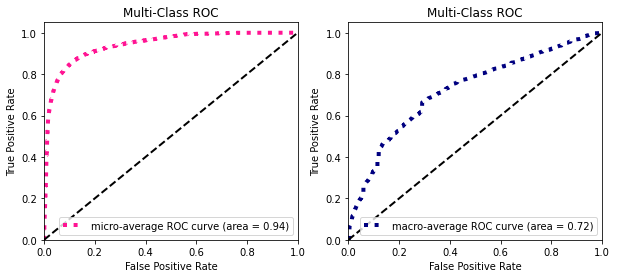

In [24]:
n_classes = 5

# Process of plotting roc-auc curve belonging to all classes.

from itertools import cycle

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC')
plt.legend(loc="lower right")

plt.subplot(122)
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC')
plt.legend(loc="lower right")
plt.show()

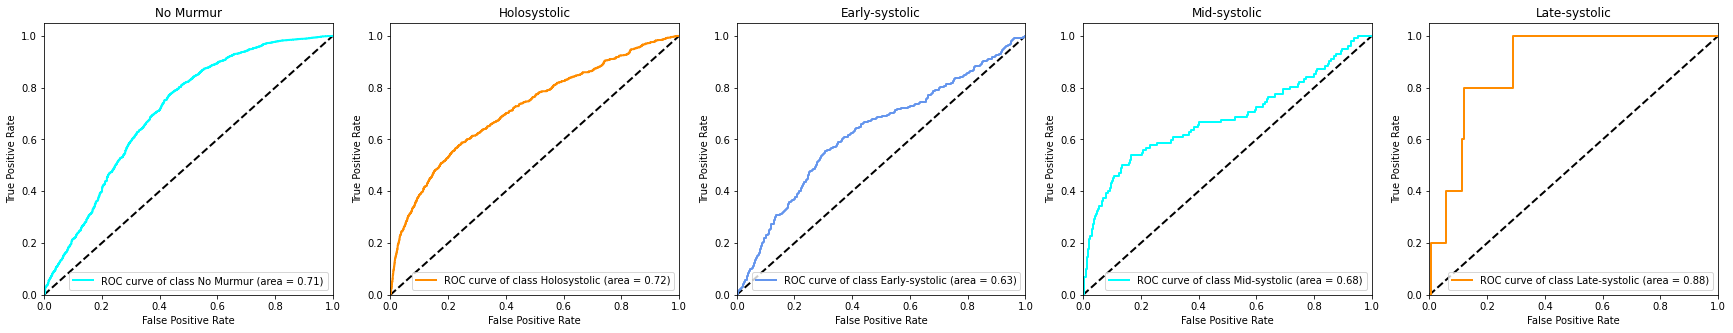

In [25]:
plt.close()
plt.figure(figsize=(30, 5))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
title = ['No Murmur', "Holosystolic", "Early-systolic", "Mid-systolic", "Late-systolic"]
for i, color in zip(range(n_classes), colors):
    if i == 0:
        plt.subplot(151)
    elif i == 1:
        plt.subplot(152)
    elif i == 2:
        plt.subplot(153)
    elif i == 3:
        plt.subplot(154)
    else:
        plt.subplot(155)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title[i])
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(title[i], roc_auc[i]))
    plt.legend(loc="lower right")
    
plt.show()

In [27]:
tfjs.converters.save_keras_model(model, "./TensorflowJS")

In [29]:
model.save("v9model.h5", save_format = "h5")